In [1]:
# this enable automatic reloading of libraries
%load_ext autoreload
%autoreload 2
from clib.bellhop import *
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
bell = bellhop({'mediterrannee': '../SSP_4profils.mat'},name='cognac_cmap',rmax=100.)

---
# Choix des paramètres 

In [ ]:
sd = 100.                              # profondeur de la source (en m)
Depth = np.arange(0.,2001.,100.)       # vecteur des profondeurs (de 0 à 2000m)
dd = Depth[1] - Depth[0]               # depth resolution (100m)
rmax = 100000.                         # range max (en m)

In [3]:
c = np.ones(21)*1500                   # profil de célérité constant (en m/s)

In [4]:
val = 12000                                           # NBeams = echantillonnage des angles
angles = np.arange(-60., 60.01, 120./val)*np.pi/180.  # de -60 à +60° par rapport à l'horizontale

---
# Tracé des rayons

In [8]:
RANGE   = np.zeros ((len(angles), 2000)) 
DEPTH   = np.zeros_like (RANGE) 
DIST    = np.zeros_like (RANGE)
REBONDS = np.zeros_like (RANGE)
LENR    = np.zeros( len(angles) )


for i in range (len (angles)) : 

    a = angles[i]    # angle choisi
    
    R = [0.]         # range de départ : 0
    D = [sd]         # profondeur de départ : prof de la source
    Dist=[0.]        # distance parcourue par le rayon
    Rebond = [0.]    # rayon réfléchi ou direct ?
    
    dist = Dist[0] 
    rang = R[0]
    depth = D[0]
    rebond = Rebond[0]

    j = 0
    while rang < rmax : 
        j+=1

        ## distance parcourue par le rayon
        dist += dd / np.sin (abs(a))

        ## profondeur
        if a < 0. :
            depth += dd
        if a > 0. :
            depth -= dd

        ## range
        if a == 0. : 
            rang = rmax
        else : 
            r_i  = dd / np.tan(abs(a))
            rang += r_i

        ## nouvel angle de travail 
        if np.logical_or (depth ==0, depth== np.max(Depth)) :  # relfection
            new_a = -a
            
            if depth == 0 : 
                if rebond != 2. :
                    rebond = 1.
            else : 
                rebond = 2.
                
        else : 
            new_a = a 
        #else :          # refraction 
        #    idx = np.where(Depth==depth)[0]
        #    if a < 0. :
        #        new_a = np.arcsin( c[idx+1]/c[idx]*np.sin(a) )
        #    if a > 0. :
        #        new_a = np.arcsin( c[idx-1]/c[idx]*np.sin(a) )        
        a = new_a
        
        
        ## sauvegarde des valeurs
        D.append(depth)
        R.append(float(rang))
        Dist.append(float(dist))
        Rebond.append(rebond)
    
    ## remplissage des arrays
    LENR[i] = len(R)
    RANGE[i,:len(R)]  = np.array(R)
    DEPTH[i,:len(R)]  = np.array(D)
    DIST[i,:len(R)]   = np.array(Dist)
    REBONDS[i,:len(R)] = np.array(Rebond)


In [10]:
np.save('LENR', LENR)
np.save('RANGE', RANGE)
np.save('DEPTH', DEPTH)
np.save('DIST', DIST)
np.save('REBONDS', REBONDS)

Nombre total de réponses impulsionnelles :  20


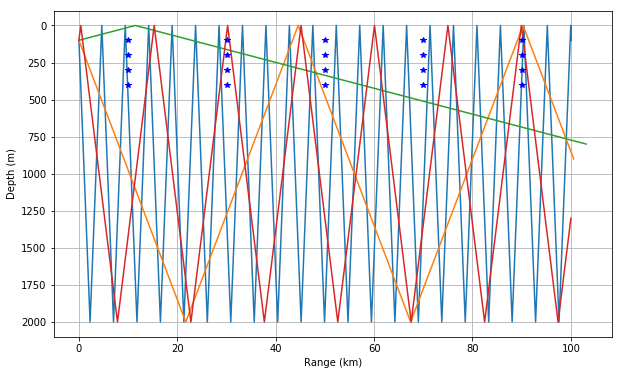

In [77]:
### Tracé de rayons
plt.figure(figsize=(10,6))
i = 2000
plt.plot(RANGE[i,:int(LENR[i])]/1000.,DEPTH[i,:int(LENR[i])])
i = 5500
plt.plot(RANGE[i,:int(LENR[i])]/1000.,DEPTH[i,:int(LENR[i])])
i = 6050 
plt.plot(RANGE[i,:int(LENR[i])]/1000.,DEPTH[i,:int(LENR[i])])
i = 7500 
plt.plot(RANGE[i,:int(LENR[i])]/1000.,DEPTH[i,:int(LENR[i])])
plt.gca().invert_yaxis()
plt.xlabel('Range (km)')
plt.ylabel('Depth (m)')
plt.grid()

### Reponses impulsionnelles
D = np.array([100., 200., 300., 400.])
R = np.array([10., 30., 50., 70., 90.]) * 1000.
print('Nombre total de réponses impulsionnelles : ', D.size * R.size)
meshD, meshR = np.meshgrid(D, R)
plt.plot(meshR/1000., meshD, '*b')
plt.show()

In [25]:
TIMES = {}
DISTANCE = {}
REB = {}
for i in range (D.size):
    d = D[i]     # chosen depth
    TIMES[str(d)] = {}
    DISTANCE[str(d)] = {}
    REB[str(d)] = {}
    
    for j in range (R.size):
        T = []
        Distance = []
        reb = []
        r = R[j]    # chosen range
        for k in range (len(angles)) : 
            idx1 = np.where( DEPTH[k,:int(LENR[k])] == d )[0]
            rr = RANGE [k, idx1]

            for l in range (rr.size) : 
                if np.logical_and( rr[l] >= r-1. , rr[l] <= r+1.) :
                    t = DIST[k,idx1[l]]/c[0]
                    T.append(t)
                    Distance.append(DIST[k,idx1[l]])
                    reb.append(REBONDS[k,idx1[l]])
        TIMES[str(d)][str(r)] = np.array(T)   
        DISTANCE[str(d)][str(r)] = np.array(Distance)
        REB[str(d)][str(r)] = np.array(reb)

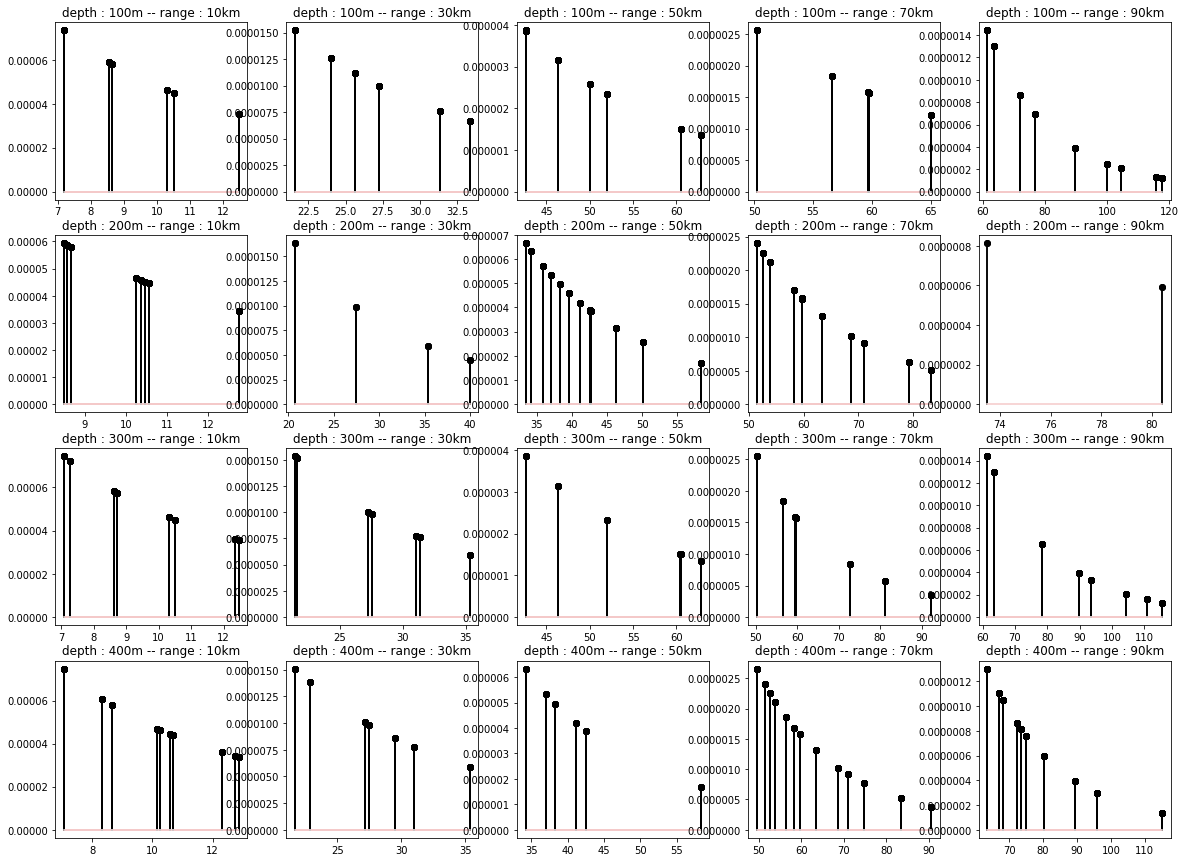

In [78]:
isd = 0       # choice of source depth

Num_arr = []
Total_time = []
Dt_first = []
Dt_second = []

#D = np.array([300.])
#R = np.array([50000.])

plt.figure(figsize=(20,15))
k = 0
for i in range (D.size):
    for j in range(R.size):
        k+=1
        d = D[i]     # choice of receiver depth
        r = R[j]     # choice of receiver range
        

        dist = DISTANCE[str(d)][str(r)] 
        t = TIMES[str(d)][str(r)] 
        reb = REB[str(d)][str(r)]

        alpha = 0.19 /1000.    # en dB/m
        TL = 20*np.log10(dist) + alpha * dist
        A = 10**(-TL/20.) 
        
        plt.subplot(D.size,R.size,k)
        for tt in range (t.size) :
            markerline, stemlines, baseline = plt.stem(t, A)
            plt.title ('depth : %dm -- range : %.dkm' %(d,r/1000.))

            if reb[tt] == 0.:
                plt.setp(stemlines, color = 'r')
                plt.setp(markerline, color = 'r')

            elif reb[tt] == 1.:
                plt.setp(stemlines, color = 'b')
                plt.setp(markerline, color = 'b')

            else : 
                plt.setp(stemlines, color = 'k')
                plt.setp(markerline, color = 'k')

        plt.setp(baseline, color='w')

        
        Narr = t.size
        Num_arr.append (Narr)
        Total_time.append(np.max(t)-np.min(t))
        sort = sorted(t)
        Dt_first.append(sort[1] - sort[0])
        
        if len(sort) >=3 : 
            Dt_second.append(sort[2] - sort[1])
        else : 
            Dt_second.append(np.NaN)
    
plt.show()           

In [11]:
# vrai profil
#creal = bell.SSP['mediterrannee']['c'][0,:]
#ccc = creal[::10]
#c = ccc[:201]